# Standalone Inference

- An example how to run inference on an image without the need to import `maskflow` and `maskrcnn-benchmark`.
- At the moment, `maskrcnn-benchmark`., is still required to be the Python paths during model loading and execution.
- In the future, we want to export the model as an ONNX graph to be able to run inference without any dependencies used to create the model. See https://github.com/facebookresearch/maskrcnn-benchmark/issues/116.

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.measure import find_contours
from skimage import transform
from PIL import Image
import torch

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Nucleus")
model_dir = root_dir / "Models"

model_name = "maskrccn-nucleus-1.0.0"
model_path = model_dir / (model_name + ".pth")

In [5]:
device = 'cuda'

# Load the model
model = torch.load(model_path)
model = model.to(device)

# Load an image
fname = root_dir / "Examples" / "example1.png"
image = np.array(Image.open(fname))
image.shape

(246, 256, 3)

In [6]:
# Preprocess inputs.
# TODO: image size and intensities means should be
# set from the model configuration YAML file.

max_size = 512
pixel_means = torch.tensor([110, 110, 110], dtype=torch.float)

w, h, c = image.shape

# Crop the image
# TODO: does not work with image larger than `max_size`.
input_tensor = torch.zeros(1, 3, max_size, max_size)
input_tensor[0, :c, :h, :w] = torch.tensor([image.T])
input_tensor = input_tensor.type(torch.FloatTensor) 

# Normalize intensities
#input_tensor = input_tensor - pixel_means[None, :, None, None]

# Run inference
input_tensor = input_tensor.to(device)
predictions = model.forward(input_tensor)

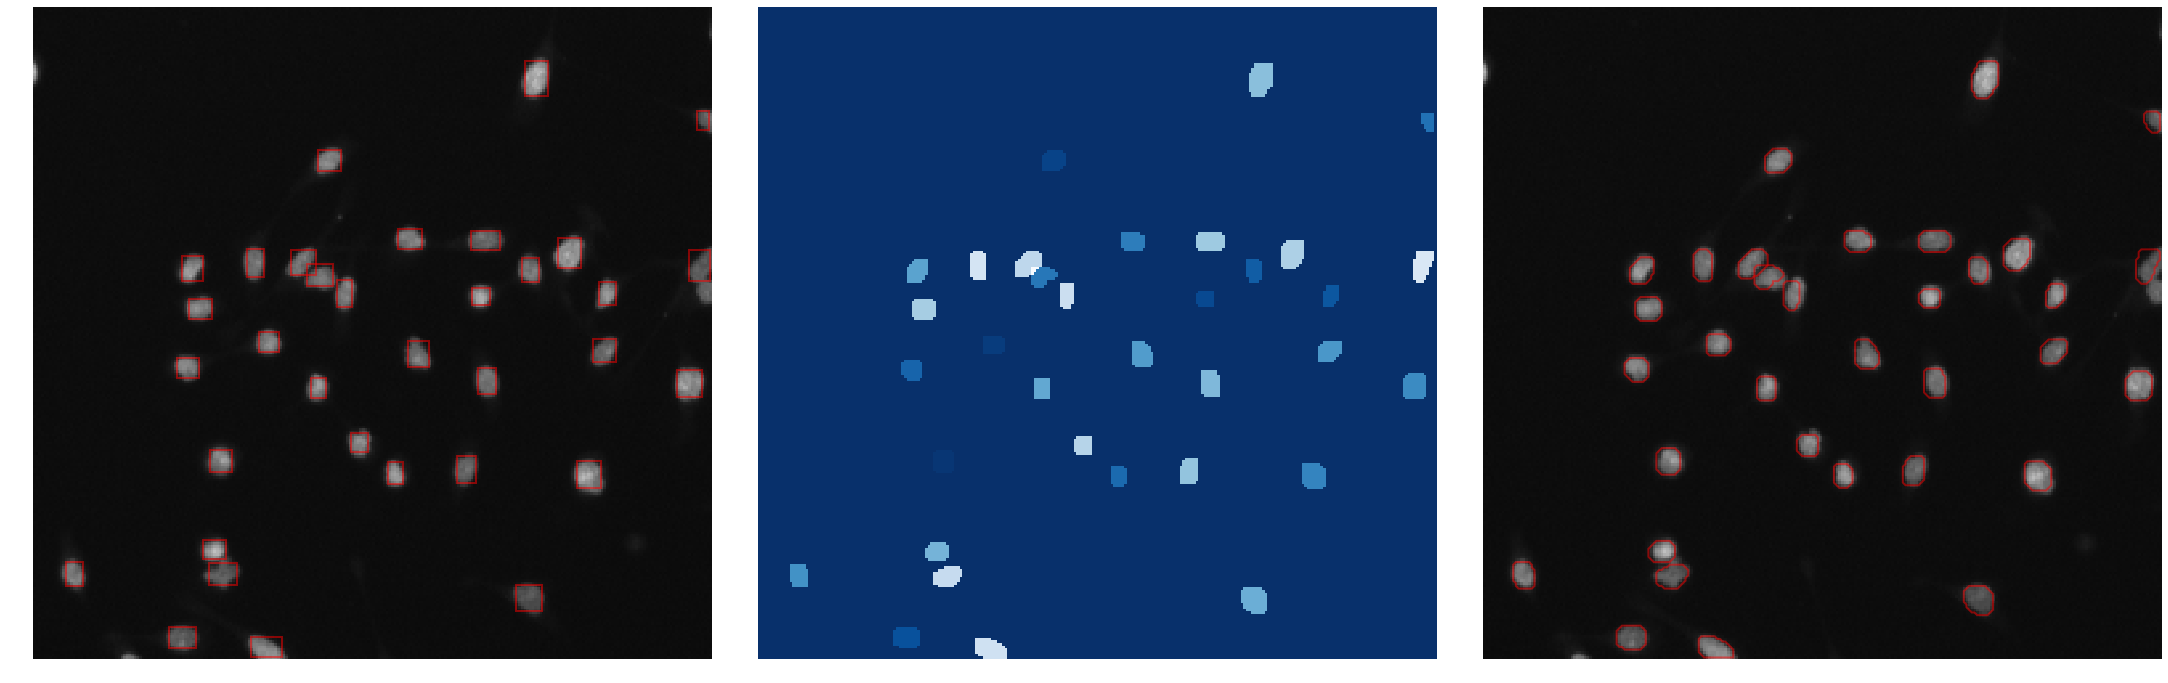

In [7]:
# Postprocess predictions.
prediction = predictions[0]

minimum_score = 0.7
mask_threshold = 0.5

boxes = prediction.bbox.to('cpu').detach().numpy()
scores = prediction.get_field('scores').to('cpu').detach().numpy()
labels = prediction.get_field('labels').to('cpu').detach().numpy()
mask = prediction.get_field('mask').to('cpu').detach().numpy()

# Keep prediction above the `minimum_score`
to_keep = np.argwhere(scores > minimum_score).T[0]
boxes = boxes[to_keep]
scores = scores[to_keep]
labels = labels[to_keep]
mask = mask[to_keep]

# Resize masks and move into the input image.
# FIXME: Looks like there is some masks not in the correct direction.
# TODO: That should be done inside the model.
# See https://github.com/facebookresearch/maskrcnn-benchmark/issues/123
new_masks = np.zeros([boxes.shape[0]] + list(image.shape[:2]))
polygons = []
for i in range(boxes.shape[0]):
    
    mask_single = mask[i]
    box = boxes[i]

    # Resize the mask
    w, h = np.round(box[2:] - box[:2]).astype('uint8')
    new_mask = transform.resize(mask_single[0], (w, h))

    # Apply threshold
    new_mask = np.array(new_mask > mask_threshold, dtype='uint8')

    # Move it on the input image
    x, y = np.round(box[:2]).astype('uint8')
    w, h = new_mask.shape
    new_masks[i, x:x+w, y:y+h] = new_mask
    
    polygon = find_contours(new_masks[i], level=0)[0]
    polygon = polygon.T[::-1].T
    polygons.append(polygon)

mask = new_masks

# Merge the masks together
multipliers = np.arange(1, mask.shape[0] + 1)[:, np.newaxis, np.newaxis]
merged_masks = np.sum(mask * multipliers, axis=0)

# Display predictions
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 16), constrained_layout=True)

ax1.imshow(image, origin=[0, 0], interpolation='none', cmap='viridis')
ax1.set_aspect('equal')

ax2.imshow(merged_masks, origin=[0, 0], interpolation='none', cmap='Blues_r')
ax2.set_aspect('equal')

ax3.imshow(image, origin=[0, 0], interpolation='none', cmap='viridis')
ax3.set_aspect('equal')

for i in range(boxes.shape[0]):
    box = boxes[i]
    single_mask = mask[i]
    polygon = polygons[i]
    
    xy = box[:2][::-1]
    h, w = box[2:] - box[:2]
    rect = patches.Rectangle(xy, w, h, color='red', alpha=0.5, fill=False, linewidth=2)
    ax1.add_artist(rect)
    
    p = patches.Polygon(polygon, color='red', alpha=0.5, fill=False, linewidth=2)
    ax3.add_artist(p)
    
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

fig.savefig(fname.with_suffix(".PREDICTIONS.png"))